# Data Analysis
## Loading fma dataset into pandas dataframe

In [5]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import matplotlib.pyplot as plt
import utils

features = utils.load('../dependencies/fma_metadata/features.csv') 
genres = utils.load('../dependencies/fma_metadata/genres.csv')
tracks = utils.load('../dependencies/fma_metadata/tracks.csv')

print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


## Compressed Dataset

Using PCA we can compress the 518 features to 11 important categories.

In [7]:
small = tracks['set', 'subset'] <= 'small'
compressed_features = pd.DataFrame(skl.decomposition.PCA(n_components=1).fit_transform(features.loc[small , 'mfcc']))

for x in features.columns.levels[0]:
        compressed_features[x] = skl.decomposition.PCA(n_components=1).fit_transform(features.loc[small , x])
# for x in features.columns.levels[0]:
#         print(x)
compressed_features['genre'] = tracks.loc[small, ('track', 'genre_top')]
compressed_features.drop(0, axis=1, inplace=True)
compressed_features = compressed_features.dropna(axis =0,subset=['genre'])
compressed_features.head()

,chroma_cens,chroma_cqt,chroma_stft,mfcc,rmse,spectral_bandwidth,spectral_centroid,spectral_contrast,spectral_rolloff,tonnetz,zcr,genre
2,3.091406,0.026566,1.312020,-111.985279,0.322551,-51.656158,-82.649364,-8.358257,125.505390,0.809858,-10.135438,Hip-Hop
5,-1.525586,2.144195,-0.620769,-190.081271,-1.785599,-215.843619,-2333.556449,9.826731,-300.121691,-2.083901,45.882215,Hip-Hop
10,-0.749335,-0.379961,-0.588454,242.075007,4.029628,-523.533701,289.511869,23.502199,-1495.529749,-1.673614,-25.008615,Pop
140,-1.026835,-0.232622,-0.784326,223.796148,0.603088,-346.166031,304.149657,17.715249,-1083.390611,0.170901,3.625271,Folk
141,-1.426853,-0.991975,-0.956121,197.810734,9.903635,-123.073270,232.220502,15.853715,-567.797722,0.667011,8.895216,Folk


## Pearson Correlation Matrix

The pearson correlation matrix shows us that most of the variables are uncorrelated. We can drop highly correlated variables such as spectral rolloff when selecting features to train.

In [8]:
corr = compressed_features.corr()

corr.style.set_precision(3).background_gradient(cmap='RdBu', vmin=-1, vmax=1)

/var/folders/lj/5l07wvkx4fbfgv9x75v_7j_40000gn/T/ipykernel_42029/2304788146.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.set_precision(3).background_gradient(cmap='RdBu', vmin=-1, vmax=1)


,chroma_cens,chroma_cqt,chroma_stft,mfcc,rmse,spectral_bandwidth,spectral_centroid,spectral_contrast,spectral_rolloff,tonnetz,zcr
chroma_cens,1.000,0.607,-0.035,-0.114,0.012,0.091,0.008,-0.147,0.123,0.262,-0.067
chroma_cqt,0.607,1.000,-0.004,0.105,-0.015,-0.128,0.061,0.120,-0.128,0.018,0.003
chroma_stft,-0.035,-0.004,1.000,0.267,0.041,-0.273,0.088,0.271,-0.239,0.210,0.300
mfcc,-0.114,0.105,0.267,1.000,0.197,-0.616,0.235,0.669,-0.609,-0.059,0.179
rmse,0.012,-0.015,0.041,0.197,1.000,0.052,0.080,0.132,0.070,-0.022,-0.017
spectral_bandwidth,0.091,-0.128,-0.273,-0.616,0.052,1.000,-0.342,-0.609,0.922,0.064,-0.248
spectral_centroid,0.008,0.061,0.088,0.235,0.080,-0.342,1.000,0.150,-0.338,-0.053,-0.117
spectral_contrast,-0.147,0.120,0.271,0.669,0.132,-0.609,0.150,1.000,-0.606,-0.080,0.184
spectral_rolloff,0.123,-0.128,-0.239,-0.609,0.070,0.922,-0.338,-0.606,1.000,0.093,-0.294
tonnetz,0.262,0.018,0.210,-0.059,-0.022,0.064,-0.053,-0.080,0.093,1.000,-0.053


## Pairplot of 11 spectral features

Let's visualize the distribution for each of the features listed above.

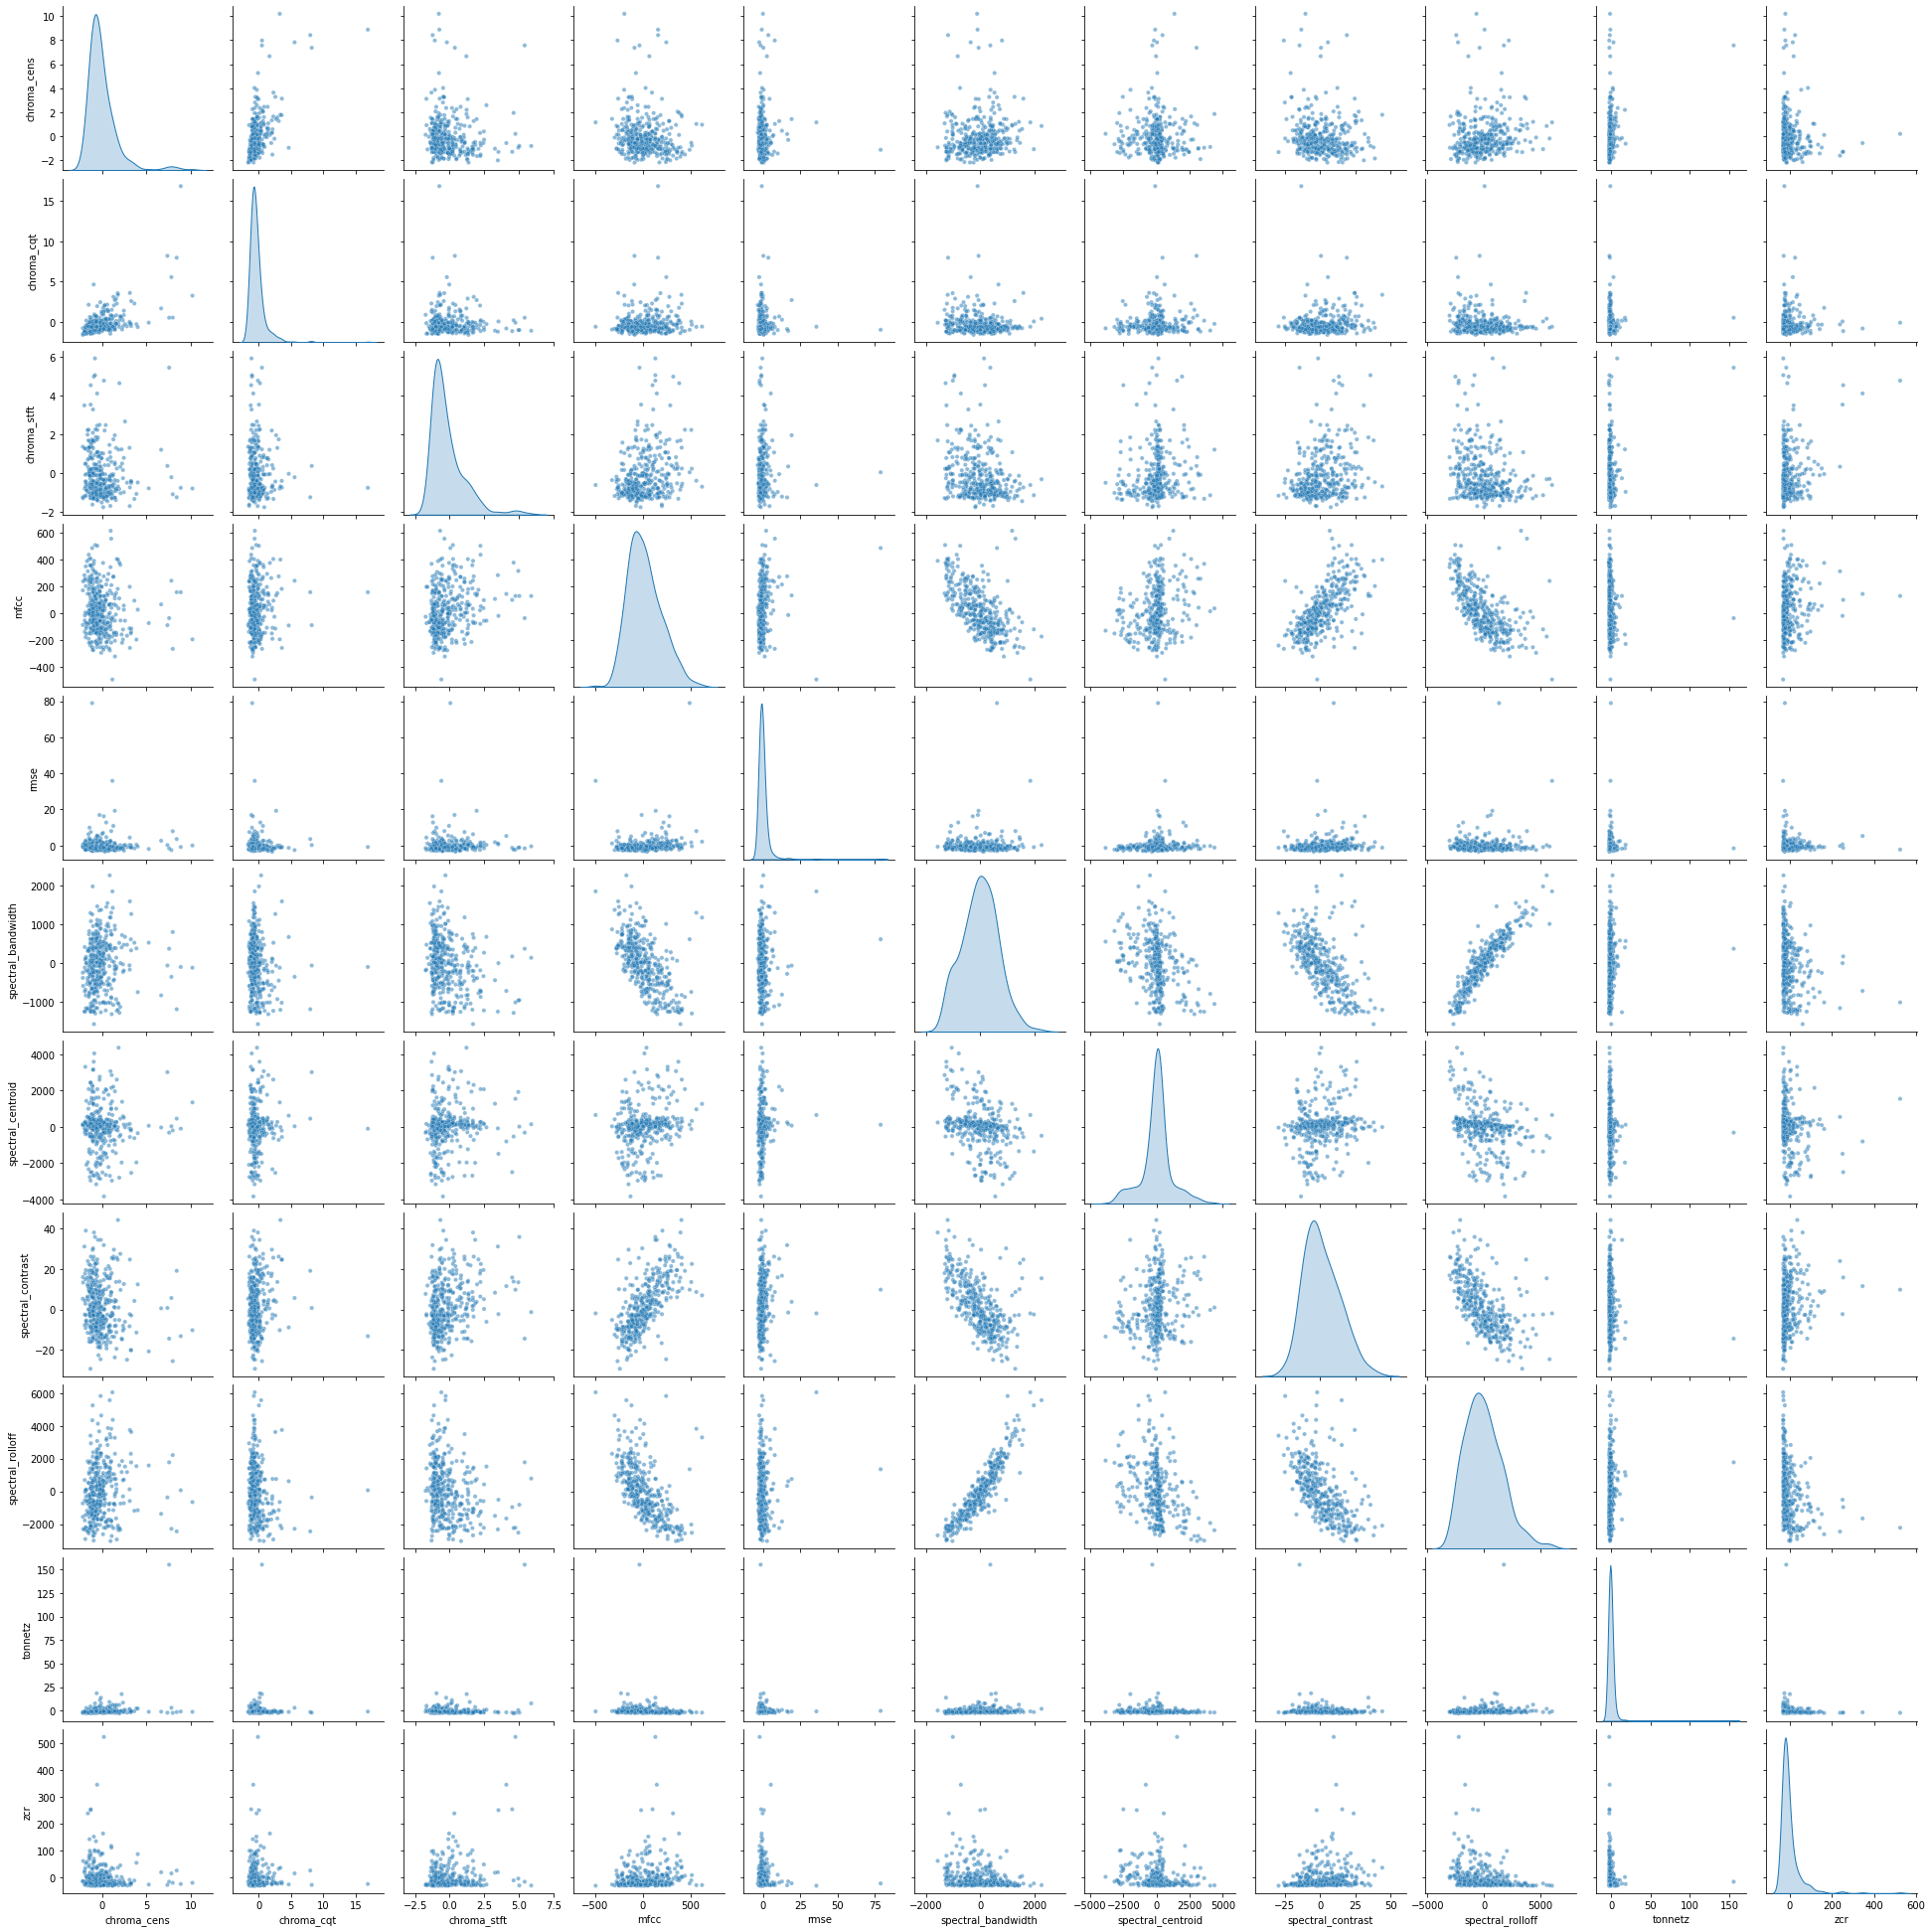

In [9]:
import seaborn as sns

sns.pairplot(data=compressed_features,
             # Variables within data to use
             vars=features.columns.levels[0],
             # Use kde for the diagonal subplots
             diag_kind='kde',
             plot_kws=dict(
                 size=.5,
                 alpha=.5,
             ))

## Genre KDE plots
From the kde plots, we can determine the kurtosis between genres, and select the features that are the most distinct.

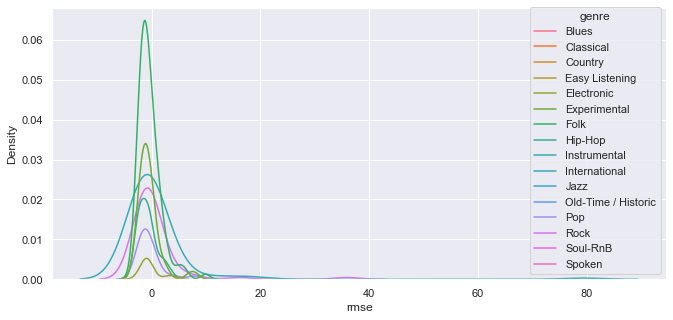

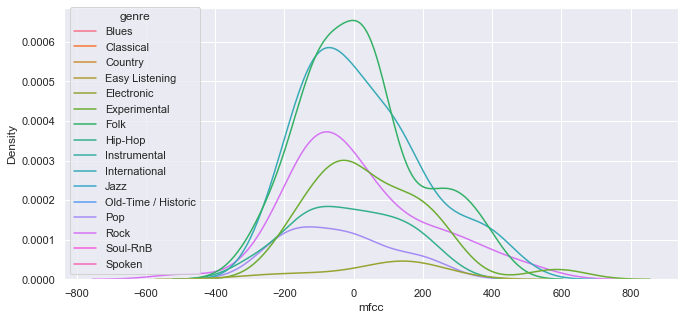

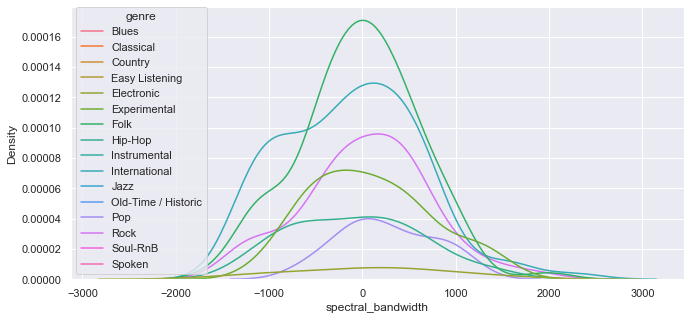

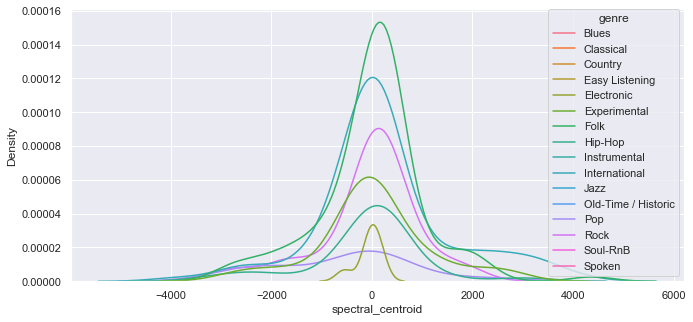

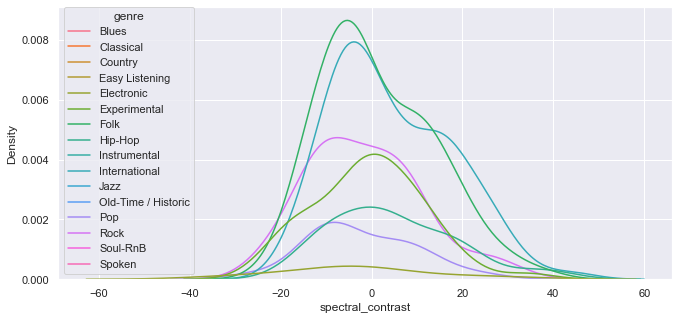

In [15]:
arr = ['rmse','mfcc','spectral_bandwidth','spectral_centroid','spectral_contrast']
for label in arr:
        plt.figure()
        sns.set(rc={'figure.figsize':(11,5)})
        sns.kdeplot(data=compressed_features,x=label,hue='genre')

## 2 Genre Comparison
Now let's visualize the features between two genres as scatterplots.

We find that features such as MFCC, rsme, spectral centroid, spectral bandwidth, and spectral contrast are the most distinct between the genres.

(106574,) (106574,) (106574,)
(2000, 84)
(2000,)


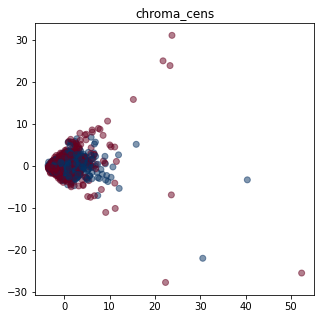

(2000, 84)
(2000,)


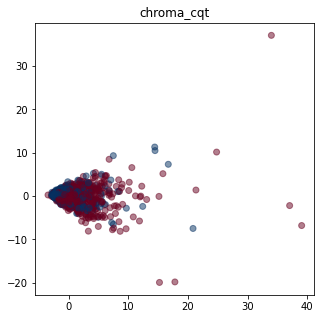

(2000, 84)
(2000,)


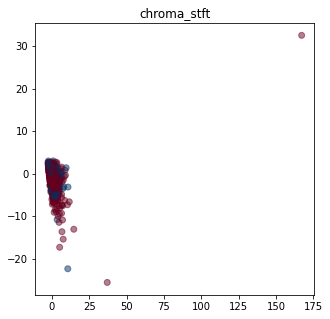

(2000, 140)
(2000,)


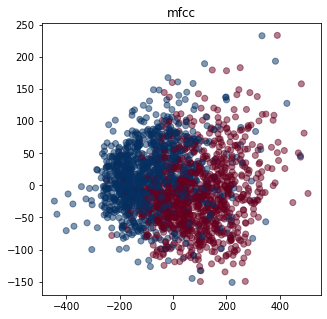

(2000, 7)
(2000,)


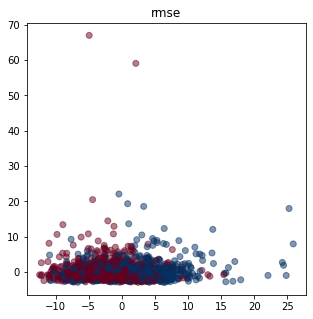

(2000, 7)
(2000,)


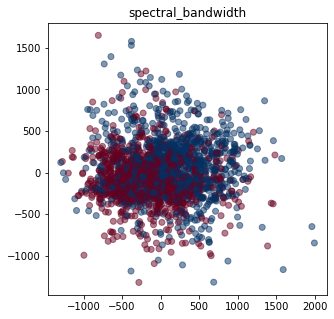

(2000, 7)
(2000,)


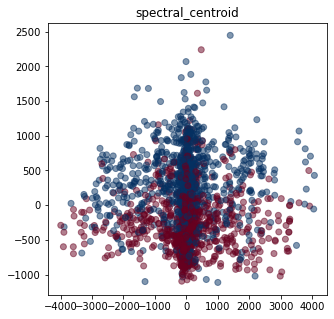

(2000, 49)
(2000,)


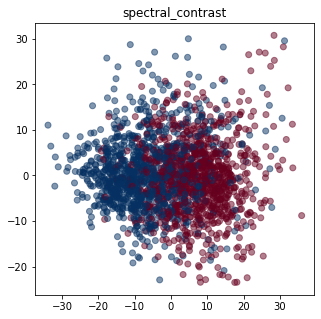

(2000, 7)
(2000,)


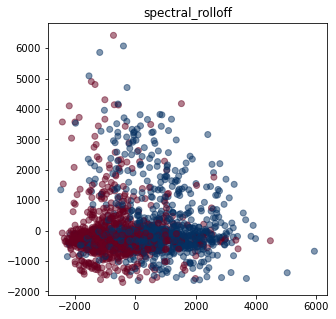

(2000, 42)
(2000,)


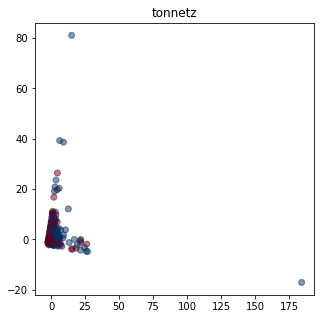

(2000, 7)
(2000,)


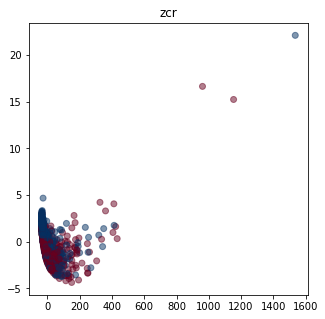

In [13]:
#One Hot Encoding Rock Genre

from sklearn.preprocessing import OneHotEncoder as enc
from sklearn.preprocessing import MinMaxScaler as minmax
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Folk'

print(small.shape, genre1.shape, genre2.shape)
for col in features.columns.levels[0]:
        X = features.loc[small & (genre1 | genre2), col]
        # X = features.loc[small & (genre1 | genre2), 'mfcc':'spectral_contrast']
        print(X.shape)

        y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
        print(y.shape)

        oh = pd.get_dummies(y, prefix='genre')
        oh.head()

        X = skl.decomposition.PCA(n_components=2).fit_transform(X)
        #X = minmax.fit_transform(X)

        y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
        y = skl.preprocessing.LabelEncoder().fit_transform(y)

        fig = plt.figure( figsize= (5,5))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
        plt.title(col)
        plt.show()
        X.shape, y.shape

## 5 Genre Scatterplot
When we plot 5 genres on the same scatterplot, we observe that there is a lot of overlap between the genres.

Through trial and error, we found that rock, electronic, pop, hip-hop, and instrumental are the most distinct genres, which we display in the scatterplots below.

(106574,) (106574,) (106574,)
(4000, 84)
(4000,)


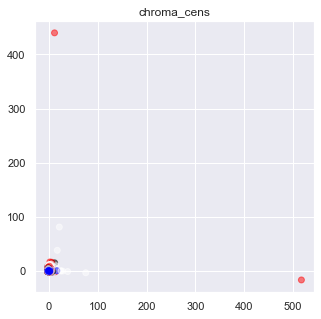

(4000, 84)
(4000,)


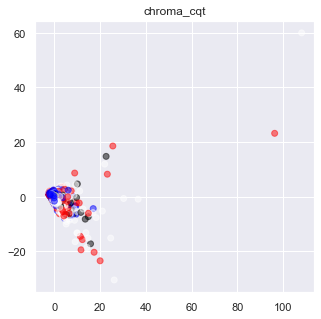

(4000, 84)
(4000,)


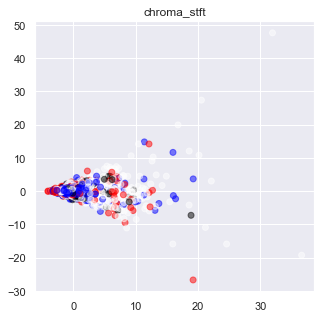

(4000, 140)
(4000,)


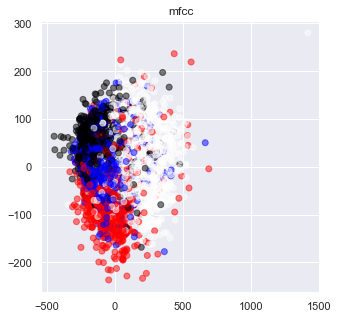

(4000, 7)
(4000,)


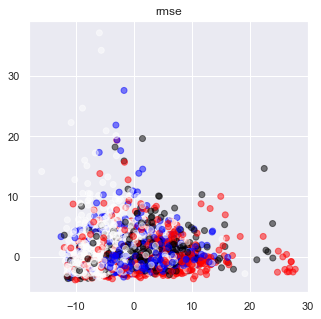

(4000, 7)
(4000,)


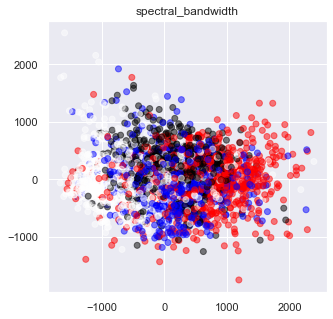

(4000, 7)
(4000,)


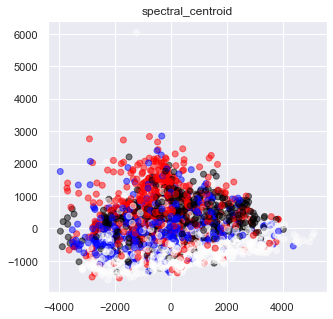

(4000, 49)
(4000,)


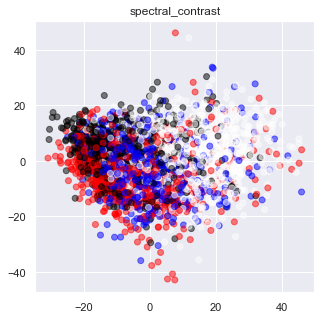

(4000, 7)
(4000,)


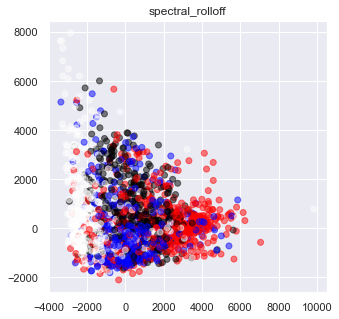

(4000, 42)
(4000,)


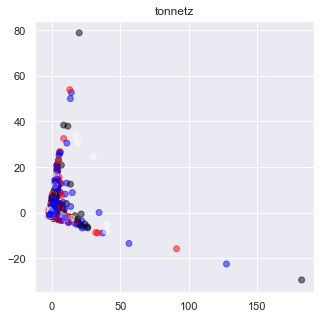

(4000, 7)
(4000,)


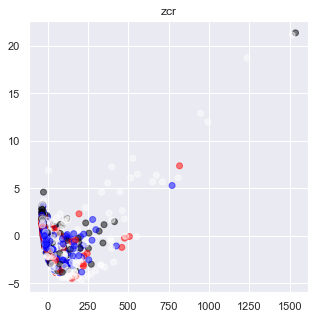

In [19]:
#One Hot Encoding Rock Genre

from sklearn.preprocessing import OneHotEncoder as enc
from sklearn.preprocessing import MinMaxScaler as minmax
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Electronic'
genre3 = tracks['track', 'genre_top'] == 'Pop'
genre4 = tracks['track', 'genre_top'] == 'Hip-hop'
genre5 = tracks['track', 'genre_top'] == 'Instrumental'


print(small.shape, genre1.shape, genre2.shape)
for col in features.columns.levels[0]:
        X = features.loc[small & (genre1 | genre2 | genre3 | genre4 | genre5), col]
        print(X.shape)

        y = tracks.loc[small & (genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
        print(y.shape)

        oh = pd.get_dummies(y, prefix='genre')
        oh.head()

        X = skl.decomposition.PCA(n_components=2).fit_transform(X)
        #X = minmax.fit_transform(X)

        y = tracks.loc[small & (genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
        y = skl.preprocessing.LabelEncoder().fit_transform(y)

        fig = plt.figure( figsize= (5,5))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='flag', alpha=0.5)
        plt.title(col)
        plt.show()
        X.shape, y.shape